Домашнее задание 10 (после Лекции №11)
Задание №1: 

1. Для любых пар изображений которые имеют общее поле зрения (две фотографии сделанные с телефона который был повернут на определенный угол - любой лишь бы было 20+% перекрытия)
Рассчитать матрицу афинного преобразования из одной системы координат в другую. Выполнить разложение данной матрицы и посчитать явно угол поворота, вектор переноса и скалирования. 
Выполнить обратное преобразование - получить афинную матрицу заново. 

Анализ задания: используем функции библиотеки OpenCV, в частности, оптический поток. Определяем набор характерных точек в каждом изображении, сопоставляем наборы точек. С помощью набора соответственных пар точек рассчитываем аффинное преобразование, переводящее один набор точек в другой.
Далее, зная структуру матрицы аффинного  преобразования, вытягиваем из нее компоненты, отвечающие за трансляцию, поворот, масштабирование и деформацию сдвига.
После этого заново собираем матрицу, уже из отдельных компонент, отвечающих за каждое аффинное преобразование.


Загрузка файлов картинок в соответствующие переменные

In [118]:
quit # reset all variables for repeated run of the program

# loading necessary libraries and two pictures
import cv2
import numpy as np
import matplotlib.pyplot as plt

path1 = 'pic1.jpg'  # 1st picture, file name (and path if necessary)
path2 = 'pic2.jpg'  # second picture
try:
    pic1 = cv2.imread(path1)
    pic2 = cv2.imread(path2)
    print('Files are loaded')
except:
    print('Error loading file') # doesn't work properly :((((



Files are loaded


Вывод загруженных картинок на экран

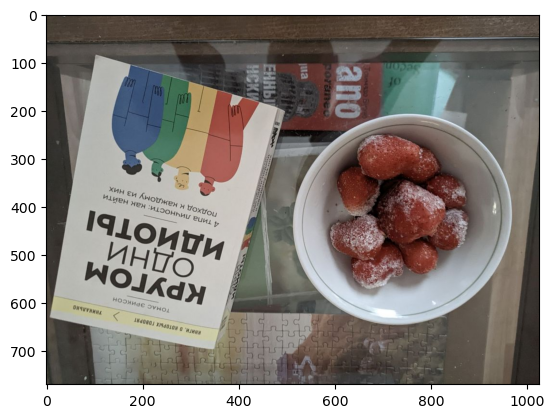

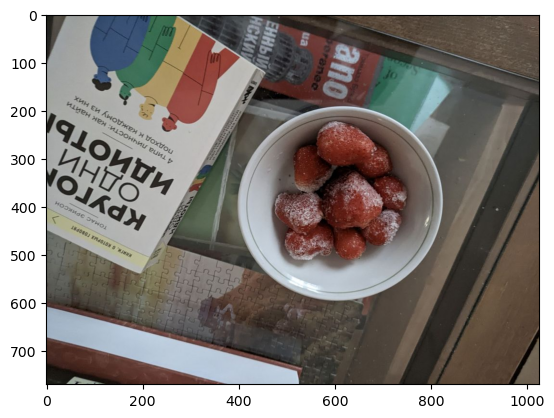

In [119]:
# cv2.imshow('1st picture', pic1)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# cv2.imshow('2nd picture', pic2)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# plt.figure(figsize=(16, 6), dpi=100)

# convert color image into RGB image 
img1 = cv2.cvtColor(pic1, cv2.COLOR_BGR2RGB) 
# show image 1
plt.imshow(img1)
plt.show()
img2 = cv2.cvtColor(pic2, cv2.COLOR_BGR2RGB) 
# show image 2
plt.imshow(img2)
plt.show()

Здесь и далее - взято из файла блокнота Юпитер к лекции и подогнано для целей данного задания
Используем оптический поток

Функция сопоставления пар точек с помощью оптического потока

In [120]:
def match_keypoints(optical_flow, prev_kps):
    """Match optical flow keypoints
    :param optical_flow: output of cv2.calcOpticalFlowPyrLK
    :param prev_kps: keypoints that were passed to cv2.calcOpticalFlowPyrLK to create optical_flow
    :return: tuple of (cur_matched_kp, prev_matched_kp)
    """
    cur_kps, status, err = optical_flow

    # storage for keypoints with status 1
    prev_matched_kp = []
    cur_matched_kp = []

    if status is None:
        return cur_matched_kp, prev_matched_kp

    for i, matched in enumerate(status):
        # store coords of keypoints that appear in both
        if matched:
            prev_matched_kp.append(prev_kps[i])
            cur_matched_kp.append(cur_kps[i])

    return cur_matched_kp, prev_matched_kp

Находим с помощью оптического потока два набора векторов, содержащих соответствующие точки изображений.
В исходном материале с лекции эта функция носила название get_transform_matrix. Это название вводит в заблуждение, поскольку можно подумать, что она возвращает матрицу аффинного преобразования. На самом деле возвращает два набора соответствующих друг другу точек двух изображений. Поэтому мы переименовали ее в get_transform_keypoints, чтобы не путаться.
Заодно эта функция формирует картинку, визуализирующую пары совпадающих точек.

In [ ]:
def get_transform_keypoints(img0, img1, method = cv2.LMEDS):
    # Функция которая принимает на вход 2 изображения и возвращает матрицу трансформации
    gray0 = cv2.cvtColor(img0, cv2.COLOR_RGB2GRAY)
    gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)

    corners0 = cv2.goodFeaturesToTrack(gray0, 50, 0.01, 40) # finds keypoints very quickly, epsilon=0.01, min_dist = 40
    
    corners1, status, err = cv2.calcOpticalFlowPyrLK(gray0, gray1, corners0, None)
    # Отбираем хорошие точки
    good_new = corners1[status == 1]
    good_old = corners0[status == 1]
    # Преобразуем точки в объекты KeyPoint
    kp1 = [cv2.KeyPoint(x=float(p[0]), y=float(p[1]), size=1) for p in good_old]
    kp2 = [cv2.KeyPoint(x=float(p[0]), y=float(p[1]), size=1) for p in good_new]
    
    # Создаем объекты DMatch
    matches = [cv2.DMatch(_imgIdx=0, _queryIdx = i, _trainIdx = i, _distance = 0) for i in range(len(kp1))]
    
    # Визуализируем совпадения
    match_img = cv2.drawMatches(img0, kp1, img1, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)    

    return match_img, kp1, kp2

Расчет векторов, содержащих соответствующие точки двух изображений

In [122]:
match_img, kp1, kp2 = get_transform_keypoints(pic1, pic2)

Вывод сопоставляемых картинок:

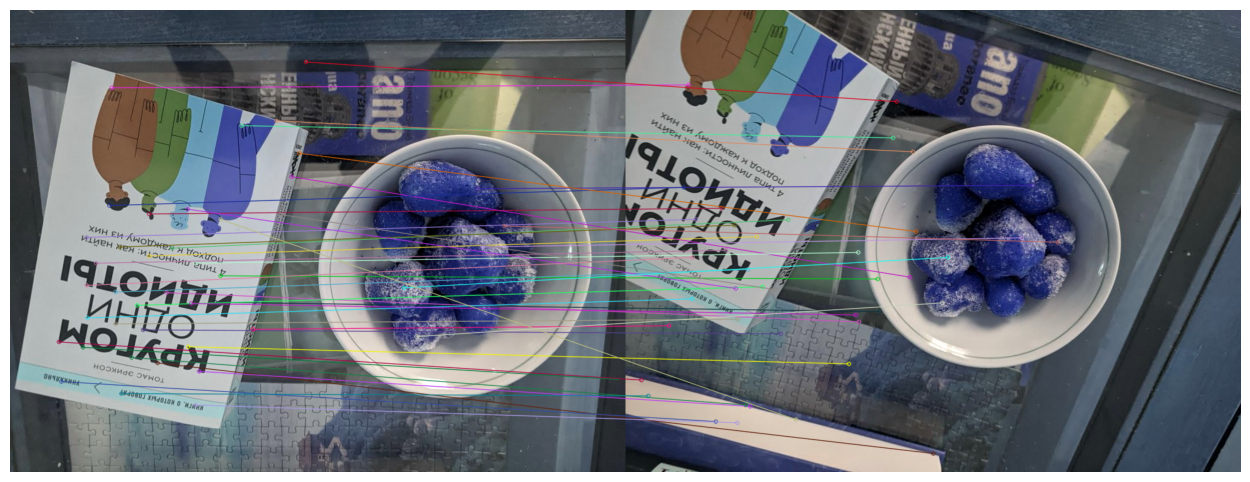

In [123]:
plt.figure(figsize = (16, 6), dpi = 100)
plt.imshow(match_img)
plt.axis('off') # remove axes
# Save plot to file
plt.savefig('plot_match_optflow.jpg', bbox_inches = 'tight', pad_inches = 0)

Результаты в массивы для использования в качестве аргумента для нахождения матрицы преобразования

In [124]:
src_pts = np.float32([m.pt for m in kp1]).reshape(-1, 1, 2)
dst_pts = np.float32([m.pt for m in kp2]).reshape(-1, 1, 2)

Функция для расчета матрицы аффинного преобразования (в примерах к лекции называлась estimate_partial_transform, мы, чтобы не путаться, переименовали в функцию estimate_affine_matrix)

In [125]:
def estimate_affine_matrix(cur_matched_kp, prev_matched_kp, method):
    """
    
    :param matched_keypoints: output of match_keypoints util function; tuple of (cur_matched_kp, prev_matched_kp)
    :return: 2D affine transform matrix 3 x 3
    """
    transform = cv2.estimateAffine2D(np.array(prev_matched_kp),
                                           np.array(cur_matched_kp),method = method)[0]  #cv2.LMEDS may be
                                                                                         
    #print(transform)    
    if transform is not None:
        # translation x
        dx = transform[0, 2]
        # translation y
        dy = transform[1, 2]
        # rotation
        da = np.arctan2(transform[1, 0], transform[0, 0])
    else:
        dx = dy = da = 0

    # return [dx, dy, da], transform
    m = [dx, dy, da]
    M = transform
    ATM = np.append(M, np.array([0,0,1])).reshape(3,3)
    return(ATM) # return affine transform matrix

Расчет матрицы 2D аффинного преобразования

In [126]:
affine_transform_matrix = estimate_affine_matrix(src_pts, dst_pts, cv2.LMEDS)
print(affine_transform_matrix)

[[ 6.96006196e-01 -7.99635398e-02  1.35466195e+02]
 [-1.16375173e-01  8.57385696e-01  7.43387731e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Декомпозиция - функция

In [127]:
import numpy as np
def decompose_affine_matrix(matrix):
    """
    Декомпозирует аффинную матрицу на компоненты: смещение, масштабирование, поворот и сдвиг.

    Args:
        matrix (numpy.ndarray): Аффинная матрица размером 3x3.

    Returns:
        dict: Словарь с компонентами: 'translation', 'scale', 'rotation_angle', 'shear'.
    """

    # Проверяем, что матрица имеет правильный размер
    if matrix.shape != (3, 3):
        raise ValueError("Матрица должна быть размером 3x3")

    # Извлекаем компоненты
    a, b, tx = matrix[0, 0], matrix[0, 1], matrix[0, 2]
    c, d, ty = matrix[1, 0], matrix[1, 1], matrix[1, 2]

    # Вычисляем смещение
    translation = (tx, ty)

    # Вычисляем масштабирование
    sx = np.sqrt(a**2 + c**2)
    sy = np.sqrt(b**2 + d**2)

    # Нормализуем для извлечения угла поворота
    if sx == 0 or sy == 0:
        raise ValueError("Масштабирование равно нулю")

    rotation_matrix = np.array([[a, b], [c, d]]) / np.array([[sx, sx], [sy, sy]])
    theta = np.arctan2(rotation_matrix[1, 0], rotation_matrix[0, 0])
    rotation_angle = np.degrees(theta)

    # Вычисляем сдвиг
    shear = (a * b + c * d) / (sx * sy)

    return {
        "translation": translation,
        "scale": (sx, sy),
        "rotation_angle": rotation_angle,
        "shear": shear
    }

Расчет декомпозиции

In [128]:
result = decompose_affine_matrix(np.linalg.inv(affine_transform_matrix))
print("Translation:", result["translation"])
print("Scale:", result["scale"])
print("Rotation angle (degrees):", result["rotation_angle"])
print("Shear:", result["shear"])

Translation: (-207.83598711214714, -114.9141191030898)
Scale: (1.4729123351811282, 1.1926062646410385)
Rotation angle (degrees): 9.5162788459563
Shear: 0.24672151162370284


Обратно - композиция матрицы из частных преобразований

In [129]:
def compose_affine_matrix(components):
    """
    Создает аффинную матрицу из компонентов: смещение, масштабирование, поворот и сдвиг.

    Args:
        components (dict): Словарь с компонентами: 'translation', 'scale', 'rotation_angle', 'shear'.

    Returns:
        numpy.ndarray: Аффинная матрица размером 3x3.
    """

    translation = components["translation"]
    scale = components["scale"]
    rotation_angle = components["rotation_angle"]
    shear = components["shear"]

    R = np.array([
        [np.cos(np.radians(rotation_angle)), np.sin(np.radians(rotation_angle)), 0],
        [-np.sin(np.radians(rotation_angle)), np.cos(np.radians(rotation_angle)), 0],
        [0, 0, 1]
    ])

    T = np.array([
        [1, 0, translation[0]],
        [0, 1, translation[1]],
        [0, 0, 1]
    ])

    S = np.array([
        [scale[0], 0, 0],
        [0, scale[1], 0],
        [0, 0, 1]
    ])

    Sh = np.array([
        [1, shear * scale[0] / scale[1], 0],
        [0, 1, 0],
        [0, 0, 1]
    ])

    A = T @ R @ Sh @ S #@ np.linalg.inv(T)

    return A



Используем для сборки матрицы из отдельных преобразований

In [130]:
# Пример использования:
components = result
matrix = compose_affine_matrix(components)
print(matrix)

[[   1.4526431     0.5555693  -207.83598711]
 [  -0.24351339    1.11611442 -114.9141191 ]
 [   0.            0.            1.        ]]


Также матрица обратного преобразования от второй картинки к первой (не путаем с восстановлением исходной матрицы обратно из элементарных аффинных преобразований, это совсем другое)

In [131]:
print(np.linalg.inv(affine_transform_matrix))

[[ 1.45952900e+00  1.36122058e-01 -2.07835987e+02]
 [ 1.98105637e-01  1.18481243e+00 -1.14914119e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Выводы:
В ходе работы проведено нахождение соответствующих пар точек на двух фото, сделанных со смещением и поворотом.
Найдена матрица аффинного преобразования, с помощью метода оптического потока библиотеки cv2.
Из данной матрицы извлечены отдельно вектор смещения, коэффициент масштабирования, угол поворота и сдвиг.
С использованием найденных отдельных аффинных преобразований обратно составлена матрица аффинного преобразования.
Также получена обратная матрица аффинного преобразования от второго кадра к первому.
К сожалению, следует констатировать расхождение результатов по методу sift и методу оптического потока.
